In [1]:
import cv2
import numpy as np
import os

In [2]:
main_dir = "dataset"

scenes_outer = os.listdir(main_dir)

rgb_images = []
hsi_images = []

In [3]:
import os
import cv2
import numpy as np

def load_rgb_hsi_images(main_dir, scenes_outer):
    rgb_images = []
    hsi_images = []

    for scene in scenes_outer:
        scene_path = os.path.join(main_dir, scene, scene)  # adjust if no inner folder
        if not os.path.isdir(scene_path):
            raise FileNotFoundError(f"Scene path not found: {scene_path}")

        # Get all files except .db
        files = [f for f in os.listdir(scene_path) if not f.lower().endswith(".db")]

        # Find RGB file (case-insensitive match)
        rgb_file = next((f for f in files if "_rgb" in f.lower() and f.lower().endswith(".png")), None)
        if rgb_file is None:
            raise FileNotFoundError(f"No RGB PNG found in {scene_path}")
        rgb = cv2.imread(os.path.join(scene_path, rgb_file))
        rgb_images.append(rgb)

        # Get and sort HSI band files
        band_files = [f for f in files if "_rgb" not in f.lower() and f.lower().endswith(".png")]
        band_files = sorted(band_files, key=lambda x: int(os.path.splitext(x)[0].split('_')[-1]))

        if len(band_files) != 31:
            raise ValueError(f"{scene}: expected 31 HSI bands, found {len(band_files)}")

        # Load HSI bands
        hsi_bands = [cv2.imread(os.path.join(scene_path, bf), cv2.IMREAD_GRAYSCALE) for bf in band_files]
        hsi_cube = np.stack(hsi_bands, axis=-1)
        hsi_images.append(hsi_cube)

    # Validation
    if len(rgb_images) != 32 or len(hsi_images) != 32:
        raise ValueError(f"Expected 32 scenes, got {len(rgb_images)} RGB and {len(hsi_images)} HSI")

    return rgb_images, hsi_images


main_dir = "dataset" 
scenes_outer = sorted(os.listdir(main_dir))  
rgb_list, hsi_list = load_rgb_hsi_images(main_dir, scenes_outer)

print(f"Loaded {len(rgb_list)} RGB images and {len(hsi_list)} HSI cubes.")




Loaded 32 RGB images and 32 HSI cubes.


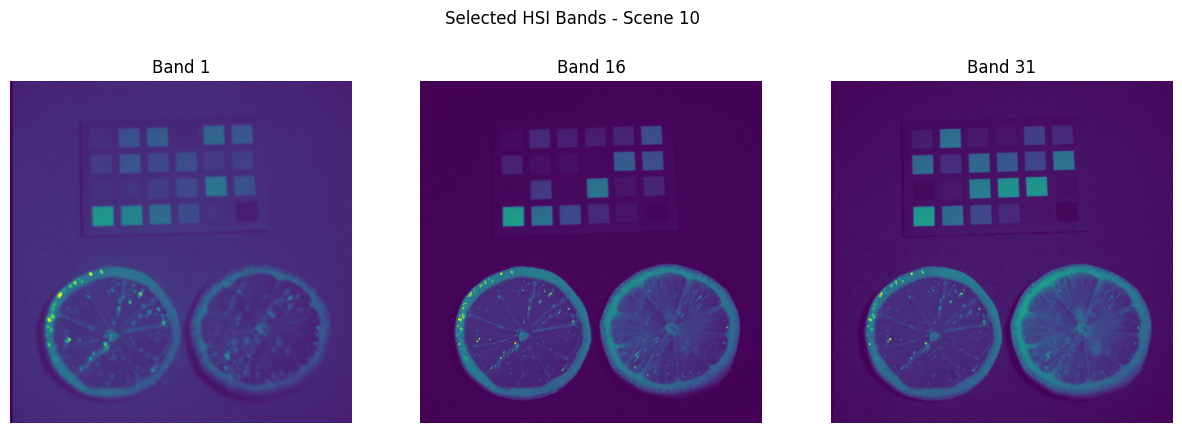

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, band in enumerate([0, 15, 30]):  # example: 400nm, ~550nm, 700nm
    axes[i].imshow(hsi_list[10][:, :, band])
    axes[i].set_title(f"Band {band+1}")
    axes[i].axis('off')

plt.suptitle(f"Selected HSI Bands - Scene {10}")
plt.show()


In [5]:
hsi_list_bhw = [np.transpose(hsi, (2, 0, 1)) for hsi in hsi_list]
rgb_list_bhw = [np.transpose(rgb, (2, 0, 1)) for rgb in rgb_list]


In [10]:
len(rgb_list_bhw)

32

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class RGBHSIDataset(Dataset):
    def __init__(self, rgb_list, hsi_list):
        """
        rgb_list: list of numpy arrays with shape (3, H, W)
        hsi_list: list of numpy arrays with shape (B, H, W)
        """
        assert len(rgb_list) == len(hsi_list), "RGB and HSI lists must have the same length"
        self.rgb_list = rgb_list
        self.hsi_list = hsi_list

    def __len__(self):
        return len(self.rgb_list)

    def __getitem__(self, idx):
        rgb = torch.tensor(self.rgb_list[idx], dtype=torch.float32)
        hsi = torch.tensor(self.hsi_list[idx], dtype=torch.float32)
        return rgb, hsi


# Assuming you already have rgb_list_bhw and hsi_list_bhw normalized to [0,1]
dataset = RGBHSIDataset(rgb_list_bhw, hsi_list_bhw)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)  # num_workers=0 for Windows

# Check one batch
for rgb_batch, hsi_batch in dataloader:
    print("RGB batch:", rgb_batch.shape)  # (B, 3, H, W)
    print("HSI batch:", hsi_batch.shape)  # (B, Bands, H, W)
    break


RGB batch: torch.Size([1, 3, 512, 512])
HSI batch: torch.Size([1, 31, 512, 512])


In [14]:
rgb, hsi = dataloader.dataset[0]  # Get first item

In [16]:
rgb.shape

torch.Size([3, 512, 512])

In [7]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt

def fit_gamma_fullcube(hsi_list_bhw,
                       force_loc0=True,
                       remove_zeros=True,
                       max_samples=None,
                       normalize=True,
                       verbose=True,
                       rng_seed=0):
    """
    Fit a single Gamma distribution to the entire HxWxC hyperspectral dataset
    (full-cube flattening across scenes and bands).

    Args:
        hsi_list_bhw (list of np.array): list of HSI cubes in (B, H, W) format.
        force_loc0 (bool): if True, fit with loc=0 (floc=0).
        remove_zeros (bool): if True, drop zero values before fitting.
        max_samples (int or None): if not None, randomly subsample up to this many voxels for fitting.
        normalize (bool): if True and data appears integer/ >1, divide by 65535.0 (common for 16-bit HSI).
        verbose (bool): print summary info.
        rng_seed (int): random seed for subsampling.

    Returns:
        params (dict): {"a": shape, "loc": loc, "scale": scale}
        fit_data (np.ndarray): the 1D array used for fitting (after preprocessing) -- returned for plotting/debugging
    """
    rng = np.random.RandomState(rng_seed)

    # Collect all voxel values (flatten across scenes and bands)
    all_vals = []
    for cube in hsi_list_bhw:
        arr = np.asarray(cube)
        if arr.ndim != 3:
            raise ValueError("Each HSI cube must be 3D (B,H,W).")
        all_vals.append(arr.ravel())
    all_vals = np.concatenate(all_vals).astype(np.float64)

    # normalization: if data is in integer range or max > 1, scale down
    if normalize and all_vals.size > 0:
        maxv = np.nanmax(all_vals)
        if maxv > 1.0:
            # assume 16-bit reflectance -> scale to [0,1]
            scale_factor = 65535.0
            if maxv < 257:   # maybe 8-bit images (0-255)
                scale_factor = 255.0
            all_vals = all_vals / float(scale_factor)
            if verbose:
                print(f"[fit_gamma_fullcube] Normalized values by {scale_factor} (max before scale = {maxv:.2f}).")

    # Remove NaNs / negatives; optionally remove zeros
    all_vals = all_vals[np.isfinite(all_vals)]
    if remove_zeros:
        all_vals = all_vals[all_vals > 0.0]
    else:
        # clamp negative to 0 (and tiny positives)
        all_vals = np.clip(all_vals, 1e-12, None)

    if all_vals.size == 0:
        raise RuntimeError("No valid positive samples found after preprocessing.")

    # Subsample for speed if requested
    if max_samples is not None and all_vals.size > max_samples:
        idx = rng.choice(all_vals.size, size=max_samples, replace=False)
        fit_vals = all_vals[idx]
        if verbose:
            print(f"[fit_gamma_fullcube] Subsampled from {all_vals.size} -> {fit_vals.size} voxels for fitting.")
    else:
        fit_vals = all_vals
        if verbose:
            print(f"[fit_gamma_fullcube] Using {fit_vals.size} voxels for fitting.")

    # Fit Gamma using MLE (SciPy). Force loc=0 if requested.
    if force_loc0:
        a, loc, scale = gamma.fit(fit_vals, floc=0)
    else:
        a, loc, scale = gamma.fit(fit_vals)

    params = {"a": float(a), "loc": float(loc), "scale": float(scale)}
    if verbose:
        print("[fit_gamma_fullcube] Fitted params:", params)

    return params, fit_vals


def plot_fit_hist_and_pdf(fit_vals, params, bins=500, title="Full-cube Gamma fit"):
    """
    Quick plotting helper: histogram + fitted Gamma PDF.
    """
    plt.figure(figsize=(6,4))
    plt.hist(fit_vals, bins=bins, density=True, alpha=0.6, color="gray", label="empirical")
    xs = np.linspace(fit_vals.min(), fit_vals.max(), 1000)
    pdf = gamma.pdf(xs, params["a"], loc=params["loc"], scale=params["scale"])
    plt.plot(xs, pdf, 'r-', lw=2, label=f'gamma pdf (a={params["a"]:.3f}, scale={params["scale"]:.4f})')
    plt.title(title)
    plt.xlabel("Reflectance (normalized)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()



[fit_gamma_fullcube] Normalized values by 255.0 (max before scale = 247.00).
[fit_gamma_fullcube] Subsampled from 242601540 -> 5000 voxels for fitting.
[fit_gamma_fullcube] Fitted params: {'a': 0.5991445434869039, 'loc': 0.0, 'scale': 0.19113133109948804}


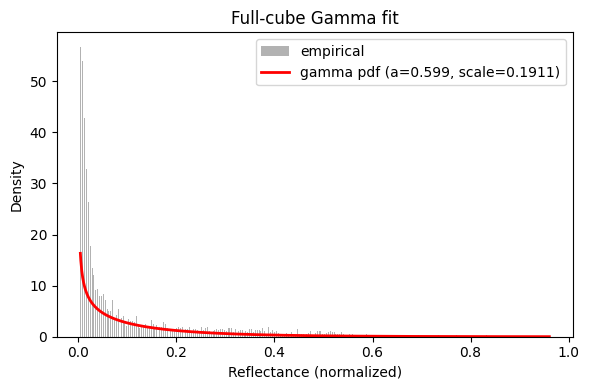

In [8]:
params, fit_vals = fit_gamma_fullcube(hsi_list_bhw, max_samples=5000, normalize=True)
plot_fit_hist_and_pdf(fit_vals, params)

In [9]:
all_hsi = np.concatenate([hsi.reshape(hsi.shape[0], -1).T for hsi in hsi_list_bhw], axis=0)
bands = all_hsi.shape[1]

In [10]:
all_hsi[0]

array([4, 3, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

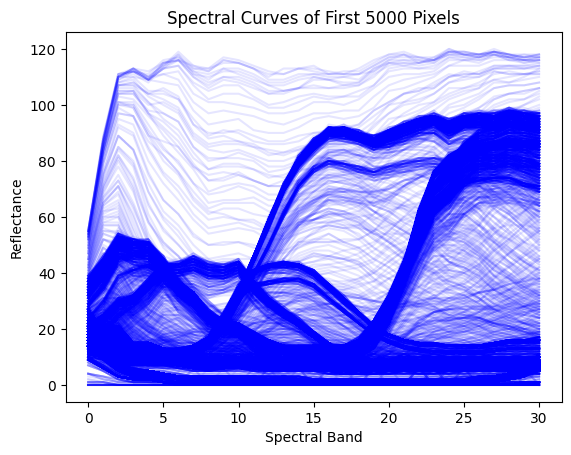

In [11]:
plt.figure()
for idx in all_hsi[:5000]:
    plt.plot(range(bands), idx, color='blue', alpha=0.1)
plt.title("Spectral Curves of First 5000 Pixels")
plt.xlabel("Spectral Band")
plt.ylabel("Reflectance")
plt.show()

In [12]:
fit_vals

array([0.10196078, 0.00784314, 0.02352941, ..., 0.02352941, 0.01176471,
       0.00392157])

Text(0.5, 0, 'Reflectance (normalized)')

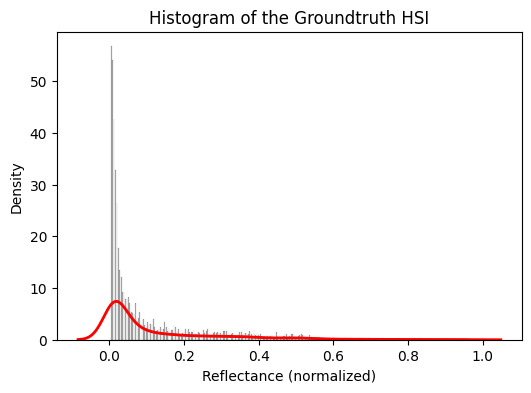

In [13]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(fit_vals, bins=500, kde=True, color='gray', label='empirical', stat='density', alpha=0.6)
sns.kdeplot(fit_vals, color='red', lw=2, label='KDE')
plt.title("Histogram of the Groundtruth HSI")
plt.xlabel("Reflectance (normalized)")

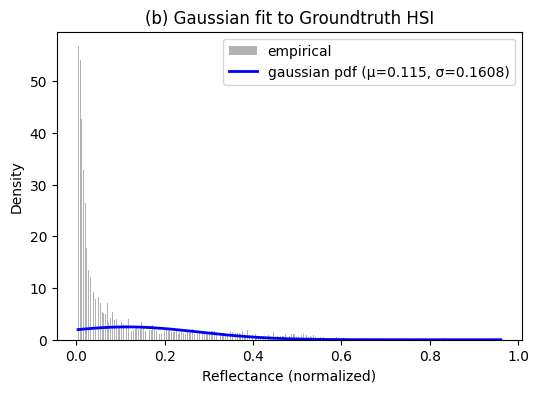

In [14]:
import scipy.stats as stats

plt.figure(figsize=(6,4))
plt.hist(fit_vals, bins=500, density=True, alpha=0.6, color="gray", label="empirical")
xs = np.linspace(fit_vals.min(), fit_vals.max(), 1000)
mu, std = np.mean(fit_vals), np.std(fit_vals)
pdf = stats.norm.pdf(xs, loc=mu, scale=std)
plt.plot(xs, pdf, 'b-', lw=2, label=f'gaussian pdf (μ={mu:.3f}, σ={std:.4f})')
plt.title("(b) Gaussian fit to Groundtruth HSI")
plt.xlabel("Reflectance (normalized)")
plt.ylabel("Density")
plt.legend()

In [15]:
mu, std

(np.float64(0.11451529411764705), np.float64(0.16083945673434427))

In [16]:
import numpy as np
import torch

def generate_gamma_cube(h, w, b, params, seed=0, normalize=True, dtype=torch.float32):
    """
    Generate a full synthetic Gamma-modeled hyperspectral cube.
    
    Args:
        h (int): Height of cube.
        w (int): Width of cube.
        b (int): Number of spectral bands.
        params (dict): {'a': shape, 'loc': loc, 'scale': scale} from fit_gamma_fullcube.
        seed (int): Random seed for reproducibility.
        normalize (bool): If True, clip values to [0,1].
        dtype: torch data type for output.

    Returns:
        torch.Tensor: Cube of shape (B, H, W) in channel-first format.
    """
    rng = np.random.default_rng(seed)

    # Generate full cube in (H, W, B) order
    cube = rng.gamma(shape=params["a"],
                     scale=params["scale"],
                     size=(h, w, b)) + params["loc"]

    # Optional normalization to [0,1]
    if normalize:
        cube_min, cube_max = cube.min(), cube.max()
        if cube_max > cube_min:
            cube = (cube - cube_min) / (cube_max - cube_min)

    # Convert to (B, H, W) and torch.Tensor
    cube_ch_first = np.transpose(cube, (2, 0, 1))
    return torch.tensor(cube_ch_first, dtype=dtype)

# Example usage:
# params from your fit_gamma_fullcube()
gamma_cube = generate_gamma_cube(512, 512, 31, params, seed=42)

print("Gamma-modeled cube shape:", gamma_cube.shape)
print("Min/Max:", gamma_cube.min().item(), gamma_cube.max().item())


Gamma-modeled cube shape: torch.Size([31, 512, 512])
Min/Max: 0.0 1.0


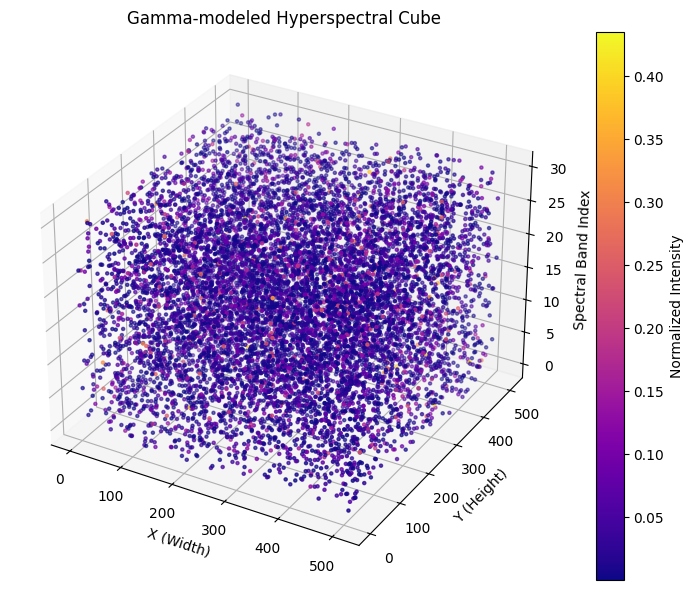

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_gamma_cube_3d(cube, max_points=5000, cmap="viridis", seed=0):
    """
    Visualize a (B, H, W) hyperspectral cube in 3D.
    
    Args:
        cube (torch.Tensor or np.ndarray): shape (B, H, W)
        max_points (int): maximum number of points to plot for speed
        cmap (str): colormap
        seed (int): random seed for reproducibility
    """
    if isinstance(cube, torch.Tensor):
        cube = cube.cpu().numpy()

    B, H, W = cube.shape
    rng = np.random.default_rng(seed)

    # Generate coordinate grid
    x_coords, y_coords, b_coords = np.meshgrid(
        np.arange(W), np.arange(H), np.arange(B), indexing='xy'
    )

    # Flatten everything
    x_flat = x_coords.ravel()
    y_flat = y_coords.ravel()
    b_flat = b_coords.ravel()
    vals_flat = cube.ravel()

    # Subsample for speed
    if len(vals_flat) > max_points:
        idx = rng.choice(len(vals_flat), size=max_points, replace=False)
        x_flat = x_flat[idx]
        y_flat = y_flat[idx]
        b_flat = b_flat[idx]
        vals_flat = vals_flat[idx]

    # 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x_flat, y_flat, b_flat, c=vals_flat, cmap=cmap, s=5)

    ax.set_xlabel("X (Width)")
    ax.set_ylabel("Y (Height)")
    ax.set_zlabel("Spectral Band Index")
    ax.set_title("Gamma-modeled Hyperspectral Cube")

    fig.colorbar(sc, ax=ax, label="Normalized Intensity")
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_gamma_cube_3d(gamma_cube, max_points=10000, cmap="plasma")


In [18]:
gamma_cube.shape

torch.Size([31, 512, 512])

In [236]:
import numpy as np
import torch

def apply_gamma_mask(cube, ratio=0.01, seed=0):
    """
    Apply a point spectra mask to the Gamma-modeled cube.
    
    Args:
        cube (torch.Tensor or np.ndarray): shape (B, H, W) - Gamma-modeled cube
        ratio (float): ratio of pixels to KEEP as point spectra (e.g., 0.0001 for 0.01%)
        seed (int): random seed for reproducibility
    
    Returns:
        masked_cube (torch.Tensor): same shape as cube, masked values
        mask (torch.Tensor): binary mask (1=keep, 0=mask out), same shape as cube
    """
    if isinstance(cube, torch.Tensor):
        cube_np = cube.cpu().numpy()
    else:
        cube_np = np.array(cube)

    B, H, W = cube_np.shape
    rng = np.random.default_rng(seed)

    # Number of pixels to keep (same spatial locations for all bands)
    total_pixels = H * W
    keep_pixels = int(np.floor(ratio * total_pixels))

    # Create flat mask for spatial positions
    spatial_mask = np.zeros(total_pixels, dtype=bool)
    spatial_mask[rng.choice(total_pixels, size=keep_pixels, replace=False)] = True
    spatial_mask = spatial_mask.reshape(H, W)

    # Broadcast mask to all bands
    mask_full = np.broadcast_to(spatial_mask, (B, H, W))

    # Apply mask
    masked_cube = cube_np * mask_full

    # Convert back to torch
    masked_cube_torch = torch.tensor(masked_cube, dtype=torch.float32)
    mask_torch = torch.tensor(mask_full.astype(np.float32), dtype=torch.float32)

    return masked_cube_torch, mask_torch


masked_cube, mask = apply_gamma_mask(gamma_cube, ratio=0.0001, seed=42)  # 0.01%
print("Masked cube shape:", masked_cube.shape)
print("Mask shape:", mask.shape)
print("Non-zero points in mask:", mask.sum().item())


Masked cube shape: torch.Size([31, 512, 512])
Mask shape: torch.Size([31, 512, 512])
Non-zero points in mask: 806.0


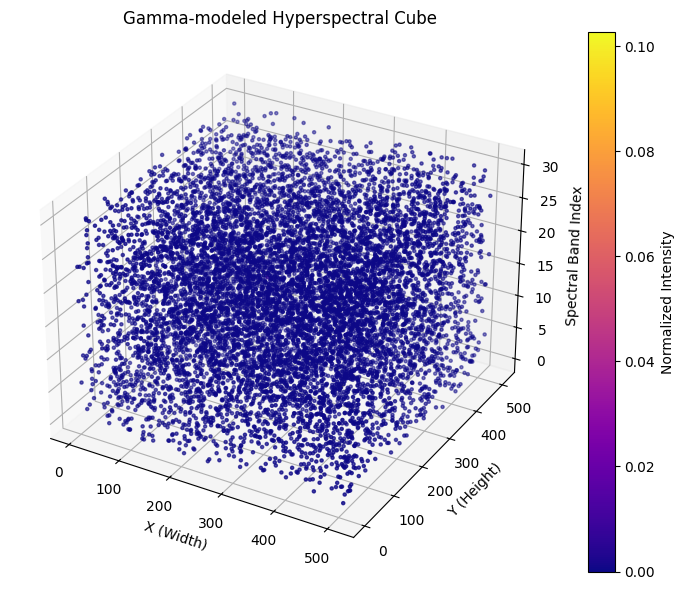

In [237]:
visualize_gamma_cube_3d(masked_cube, max_points=10000, cmap="plasma")

In [247]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch_frft.frft_module import frft, ifrft

# --------------------------
# Utilities: scanning index creation
# --------------------------
def make_scan_indices(H, W, mode):
    coords = []
    if mode == 'row':
        for r in range(H):
            for c in range(W):
                coords.append((r, c))
    elif mode == 'col':
        for c in range(W):
            for r in range(H):
                coords.append((r, c))
    elif mode == 'diag':
        for s in range(H + W - 1):
            for r in range(H):
                c = s - r
                if 0 <= c < W:
                    coords.append((r, c))
    elif mode == 'diag_rev':
        for s in range(H + W - 2, -1, -1):
            for r in range(H):
                c = s - r
                if 0 <= c < W:
                    coords.append((r, c))
    else:
        raise ValueError("unknown mode")
    return coords

def coords_to_rowmajor_idx(coords, W):
    return [r * W + c for (r, c) in coords]

def inverse_permutation(idx_list):
    L = len(idx_list)
    inv = [0] * L
    for j, val in enumerate(idx_list):
        inv[val] = j
    return inv

# --------------------------
# Sin-Cos Positional Encoding
# --------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, J, D):
        super().__init__()
        self.register_buffer("pos_emb", self._build_positional_encoding(J, D), persistent=False)

    def _build_positional_encoding(self, J, D):
        pos = torch.arange(J, dtype=torch.float).unsqueeze(1)   # (J,1)
        i = torch.arange(D, dtype=torch.float).unsqueeze(0)     # (1,D)
        div_term = torch.exp(-math.log(10000.0) * (2 * (i // 2) / D))
        pe = torch.zeros(J, D)
        pe[:, 0::2] = torch.sin(pos * div_term[:, 0::2])
        pe[:, 1::2] = torch.cos(pos * div_term[:, 1::2])
        return pe.unsqueeze(0)  # (1,J,D)

    def forward(self, x):  # (B,J,D)
        return x + self.pos_emb.to(x.device)

# --------------------------
# Vision Mamba VIM block (forward/backward selective SSM)
# --------------------------
class VimBlock(nn.Module):
    """
    Input:  tokens (B, J, D)
    Output: tokens (B, J, D)
    Hyper-params:
      D: token hidden width
      E: expanded width for x/z streams
      N: SSM state size
    """
    def __init__(self, D, E=384, N=16, conv_ks=3):
        super().__init__()
        self.D, self.E, self.N = D, E, N

        # Pre-norm
        self.norm = nn.LayerNorm(D)

        # Two linear projections -> x, z  (both shape E)
        self.to_x = nn.Linear(D, E)
        self.to_z = nn.Linear(D, E)

        # Depthwise Conv1d along sequence (forward/backward)
        padding = conv_ks // 2
        self.conv_fwd = nn.Conv1d(E, E, kernel_size=conv_ks, padding=padding, groups=E, bias=True)
        self.conv_bwd = nn.Conv1d(E, E, kernel_size=conv_ks, padding=padding, groups=E, bias=True)

        # Generate per-token SSM parameters (B_t, C_t, Δ_t) in state space N
        self.gen_B_f = nn.Linear(E, N)
        self.gen_C_f = nn.Linear(E, N)
        self.gen_D_f = nn.Linear(E, N)

        self.gen_B_b = nn.Linear(E, N)
        self.gen_C_b = nn.Linear(E, N)
        self.gen_D_b = nn.Linear(E, N)

        # Learnable diagonal A (kept stable via -softplus)
        self.A_log = nn.Parameter(torch.zeros(N))  # (N,)

        # Project token content (E) -> state space (N) for driving input u_t
        self.in_to_state = nn.Linear(E, N)

        # Readout: state (N) -> E, then to D
        self.readout = nn.Linear(N, E)
        self.proj_out = nn.Linear(E, D)

        # Gate activation for z
        self.act = nn.SiLU()

    @torch.no_grad()
    def _stable_A(self):
        # Negative diagonal for stability
        return -F.softplus(self.A_log).view(1, 1, -1)  # (1,1,N) broadcastable

    def _discretize(self, B, Delta):
        """
        ZOH discretization for diagonal A:
          A_bar = exp(Delta * A)
          B_bar = (A_bar - 1) / A * B     (elementwise)
        Shapes:
          B, Delta: (B,J,N)
        Returns:
          A_bar, B_bar: (B,J,N)
        """
        A = self._stable_A()               # (1,1,N)
        A_bar = torch.exp(Delta * A)       # (B,J,N)  broadcasting
        eps = 1e-6
        factor = (A_bar - 1.0) / (A + eps) # (B,J,N)
        B_bar = factor * B                 # (B,J,N)
        return A_bar, B_bar

    def _scan_direction(self, x_tokens, conv, gen_B, gen_C, gen_D):
        """
        One directional SSM pass.
        Args:
          x_tokens: (B,J,E)
          conv: depthwise conv1d module
          gen_B/C/D: linear generators (E->N)
        Returns:
          y: (B,J,E)
        """
        Bsz, J, E = x_tokens.shape

        # Depthwise conv along sequence: (B,E,J) -> (B,E,J) -> (B,J,E)
        x_conv = conv(x_tokens.transpose(1, 2)).transpose(1, 2)  # (B,J,E)

        # Per-token SSM parameters in state space
        B_t = gen_B(x_conv)                 # (B,J,N)
        C_t = gen_C(x_conv)                 # (B,J,N)
        Delta_t = F.softplus(gen_D(x_conv)) # (B,J,N), positive

        # Discretize A,B with ZOH
        A_bar, B_bar = self._discretize(B_t, Delta_t)  # (B,J,N)

        # Recurrent scan over sequence
        h = torch.zeros(Bsz, self.N, device=x_tokens.device, dtype=x_tokens.dtype)  # (B,N)
        Ys = []
        for t in range(J):
            # Project token content into state space as driving input u_t (B,N)
            u_t = self.in_to_state(x_conv[:, t, :])    # (B,N)
            # State update (elementwise on N)
            h = A_bar[:, t, :] * h + B_bar[:, t, :] * u_t  # (B,N)
            # Readout: (h ⊙ C_t) -> E
            y_t = self.readout(h * C_t[:, t, :])            # (B,E)
            Ys.append(y_t)

        y = torch.stack(Ys, dim=1)  # (B,J,E)
        return y

    def forward(self, tokens):  # (B,J,D)
        # Pre-norm
        t = self.norm(tokens)                  # (B,J,D)

        # Two streams: x (content) and z (gate)
        x = self.to_x(t)                       # (B,J,E)
        z = self.to_z(t)                       # (B,J,E)
        gate = torch.sigmoid(self.act(z))      # (B,J,E)

        # Forward and backward SSM passes
        y_f = self._scan_direction(x, self.conv_fwd, self.gen_B_f, self.gen_C_f, self.gen_D_f)  # (B,J,E)

        x_rev = torch.flip(x, dims=[1])
        y_b_rev = self._scan_direction(x_rev, self.conv_bwd, self.gen_B_b, self.gen_C_b, self.gen_D_b)
        y_b = torch.flip(y_b_rev, dims=[1])    # (B,J,E)

        # Gate + fuse, project back to D, residual add
        y = (y_f + y_b) * gate                 # (B,J,E)
        out = self.proj_out(y)                 # (B,J,D)
        return tokens + out

# --------------------------
# MScanBlock (ViM-style patch tokenization, fusion AFTER folding)
# --------------------------
class MScanBlock(nn.Module):
    def __init__(self, in_ch=40, patch_size=16, embed_dim=256, H=512, W=512,
                 paths=('row','col','diag','diag_rev'),
                 vim_E=384, vim_N=16, vim_ks=3):
        super().__init__()
        self.in_ch = in_ch
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.H, self.W = H, W
        self.paths = paths
        self.num_patches = (H // patch_size) * (W // patch_size)

        # Patch vector (P²·C) → D
        self.proj_in = nn.Linear(patch_size * patch_size * in_ch, embed_dim)

        # Positional encoding (sin–cos)
        self.pos_embed = PositionalEncoding(self.num_patches, embed_dim)

        # Vim blocks per path
        self.vims = nn.ModuleList([
            VimBlock(D=embed_dim, E=vim_E, N=vim_N, conv_ks=vim_ks)
            for _ in range(len(paths))
        ])

        # D → patch space, then fold
        self.proj_out = nn.Linear(embed_dim, patch_size * patch_size * in_ch)

        # Fuse full images from all paths
        self.fuse_conv = nn.Conv2d(len(paths) * in_ch, in_ch, kernel_size=3, padding=1)

    def forward(self, feat):  # feat: (B, C, H, W)
        B, C, H, W = feat.shape
        P = self.patch_size
        hP, wP = H // P, W // P
        assert C == self.in_ch
        assert H % P == 0 and W % P == 0

        # Patchify → (B, J, C*P*P)
        patches = F.unfold(feat, kernel_size=P, stride=P).transpose(1, 2)  # (B,J,CP2)

        # Project to D and add positional encoding
        tokens = self.proj_in(patches)          # (B,J,D)
        tokens = self.pos_embed(tokens)         # (B,J,D)

        path_imgs = []
        for i, mode in enumerate(self.paths):
            coords = make_scan_indices(hP, wP, mode)
            idx = coords_to_rowmajor_idx(coords, wP)
            inv_idx = inverse_permutation(idx)

            # Reorder by scan, Vim, restore
            tokens_scan = tokens[:, idx, :]             # (B,J,D)
            tokens_out = self.vims[i](tokens_scan)      # (B,J,D)
            tokens_out = tokens_out[:, inv_idx, :]      # (B,J,D)

            # Project back to patch space and fold to image
            patch_feats = self.proj_out(tokens_out).transpose(1, 2)  # (B, C*P*P, J)
            img_path = F.fold(patch_feats, output_size=(H, W), kernel_size=P, stride=P)  # (B,C,H,W)
            path_imgs.append(img_path)

        # Fuse full-path images
        concat_img = torch.cat(path_imgs, dim=1)        # (B, len(paths)*C, H, W)
        out = self.fuse_conv(concat_img)                # (B, C, H, W)
        return out

# --------------------------
# FRFT modules
# --------------------------
class MFrFT(nn.Module):
    def __init__(self, a0=0.5, a1=0.5):
        super().__init__()
        self.a0 = a0
        self.a1 = a1

    def forward(self, x):
        # Apply 2D FRFT: first along height, then width
        return frft(frft(x, self.a0, dim=-2), self.a1, dim=-1)

class MiFrFT(nn.Module):
    def __init__(self, a0=0.5, a1=0.5):
        super().__init__()
        self.a0 = a0
        self.a1 = a1

    def forward(self, x):
        return torch.abs(ifrft(ifrft(x, self.a0, dim=-2), self.a1, dim=-1))
    

import torch
import torch.nn as nn
import torch.nn.functional as F

class SpaHF(nn.Module):
    """
    Spa-HF Prompt (P_hf)
    F2 = up(avgpool(F1))
    P_hf = Conv3x3(GELU(Conv3x3(F1 - F2)))

    Args:
        C:        # channels of F1
        pool:     pooling factor (int or tuple). e.g., 2, 4
        up_mode:  'bilinear' (default) or 'nearest'
    """
    def __init__(self, C, pool=2, up_mode='bilinear'):
        super().__init__()
        self.avg = nn.AvgPool2d(kernel_size=pool, stride=pool)
        # upsample back to original size
        if up_mode == 'bilinear':
            self.up = lambda x, size: F.interpolate(x, size=size, mode='bilinear', align_corners=False)
        else:
            self.up = lambda x, size: F.interpolate(x, size=size, mode='nearest')

        self.refine = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=3, padding=1),
            nn.GELU(),                      # M_GeLU
            nn.Conv2d(C, 3, kernel_size=3, padding=1)
        )

    def forward(self, F1):                   # F1: (B, C, H, W)
        H, W = F1.shape[-2:]
        F2_low = self.avg(F1)                # low-pass
        F2 = self.up(F2_low, size=(H, W))    # back to (H,W)
        hf = F1 - F2                         # high-frequency residue
        Phf = self.refine(hf)                # two 3x3 + GeLU
        return Phf, F2, hf                   # return extras if you want to visualize

import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F

class SpectralWiseMSA(nn.Module):
    """
    Spectral-wise Multi-head Self-Attention (S-MSA)
    Inputs:
        X_in : (B, C, H, W)   # feature map sorted by wavelength along C
    Outputs:
        X_out: (B, C, H, W)   # refined features
        Pspe : (B, C, C)      # spectral prompt matrix per sample (block-diag of per-head attentions)

    Notes:
    - Attention is along the spectral (channel) dimension.
    - Q,K,V are (B, HW, C); each head is (B, HW, d_h).
    - A_j = softmax(σ_j * K_j^T @ Q_j) ∈ R^{d_h × d_h}
    - head_j = V_j @ A_j ∈ R^{HW × d_h}; concat over heads → (B, HW, C)
    """
    def __init__(self, C: int, heads: int = 1):
        super().__init__()
        assert C % heads == 0, "C must be divisible by number of heads"
        self.C = C
        self.heads = heads
        self.dh = C // heads

        # Linear projections over spectral channels (last dim)
        self.w_q = nn.Linear(C, C, bias=False)
        self.w_k = nn.Linear(C, C, bias=False)
        self.w_v = nn.Linear(C, C, bias=False)

        # Per-head learnable scaling σ_j
        self.sigmas = nn.Parameter(torch.ones(heads))

        # Final projection W ∈ R^{C×C}
        self.w_out = nn.Linear(C, C, bias=False)

        # Positional embedding fp(·): two depth-wise conv3×3 + GELU
        # Applied to V reshaped to (B,C,H,W), then reshaped back to (B,HW,C)
        self.pos_dw1 = nn.Conv2d(C, C, kernel_size=3, padding=1, groups=C, bias=True)
        self.pos_dw2 = nn.Conv2d(C, C, kernel_size=3, padding=1, groups=C, bias=True)
        self.pos_act = nn.GELU()

    def forward(self, X_in: torch.Tensor):
        B, C, H, W = X_in.shape
        HW = H * W

        # ---- 1) Flatten spatial → tokens across spectral channels
        # (B,C,H,W) -> (B,HW,C)
        X = X_in.permute(0, 2, 3, 1).reshape(B, HW, C)

        # ---- 2) Linear projections
        Q = self.w_q(X)   # (B,HW,C)
        K = self.w_k(X)   # (B,HW,C)
        V = self.w_v(X)   # (B,HW,C)

        # ---- 3) Split into heads along spectral channels
        # (B,HW,C) -> list of (B,HW,dh)
        Qh = Q.split(self.dh, dim=-1)
        Kh = K.split(self.dh, dim=-1)
        Vh = V.split(self.dh, dim=-1)

        heads_out = []
        blocks = []  # to assemble Pspe as block-diagonal
        for j in range(self.heads):
            Qj = Qh[j]                      # (B,HW,dh)
            Kj = Kh[j]                      # (B,HW,dh)
            Vj = Vh[j]                      # (B,HW,dh)

            # A_j = softmax(σ_j * K_j^T @ Q_j) over last dim
            # (B,dh,HW) @ (B,HW,dh) -> (B,dh,dh)
            attn_logits = torch.matmul(Kj.transpose(1, 2), Qj)  # (B,dh,dh)
            attn = F.softmax(self.sigmas[j] * attn_logits, dim=-1)  # (B,dh,dh)

            # head_j = V_j @ A_j  -> (B,HW,dh)
            head_j = torch.matmul(Vj, attn)  # (B,HW,dh)
            heads_out.append(head_j)
            blocks.append(attn)               # keep for Pspe

        # ---- 4) Concat heads and final projection
        Hcat = torch.cat(heads_out, dim=-1)         # (B,HW,C)
        Hproj = self.w_out(Hcat)                    # (B,HW,C)

        # ---- 5) Positional embedding fp(V)
        V_spatial = V.view(B, H, W, C).permute(0, 3, 1, 2)  # (B,C,H,W)
        pos = self.pos_dw2(self.pos_act(self.pos_dw1(V_spatial)))  # (B,C,H,W)
        pos = pos.permute(0, 2, 3, 1).reshape(B, HW, C)            # (B,HW,C)

        # ---- 6) Output + reshape back
        X_out = Hproj + pos                              # (B,HW,C)
        X_out = X_out.view(B, H, W, C).permute(0, 3, 1, 2)  # (B,C,H,W)

        # ---- 7) Spectral prompt P_spe ∈ R^{B×C×C} as block-diagonal of per-head A_j
        # Build a block-diagonal matrix from N blocks (each B×dh×dh)
        Pspe = X_in.new_zeros(B, C, C)
        offset = 0
        for j in range(self.heads):
            dh = self.dh
            Pspe[:, offset:offset+dh, offset:offset+dh] = blocks[j]
            offset += dh

        return X_out, Pspe


class SpectralPrompt(nn.Module):
    """
    Spectral Prompt Pspe construction.
    
    Inputs:
        X     : (B,3,H,W)    # original RGB image
        Ypg   : (B,C,H,W)    # gamma-modeled spectra (point spectra with channels=C)
        Pspa  : (B,3,H,W)    # spatial prompt (RGB-like)
        Phf   : (B,3,H,W)    # high-frequency prompt (RGB-like)
    
    Output:
        Y3    : (B,C,H,W)    # preliminary HSI reconstruction
    """
    def __init__(self, C=31):  # C = number of spectral bands (example 31 for HSI)
        super().__init__()
        # For Y1 creation
        self.conv1 = nn.Conv2d(C + 1, C, kernel_size=3, padding=1)  # concat(Ypg, Xm)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        
        # For Y2 and Y3 refinement
        self.conv_spa = nn.Conv2d(C + 3, C, kernel_size=3, padding=1)   # concat Y1, Pspa
        self.conv_hf  = nn.Conv2d(C + 3, C, kernel_size=3, padding=1)   # concat Y2, Phf
        
        self.act = nn.GELU()

    def forward(self, X, Ypg, Pspa, Phf):
        # Step 1: Xm = mean RGB
        Xm = torch.mean(X, dim=1, keepdim=True)   # (B,1,H,W)

        # Step 2: Y1
        cat1 = torch.cat([Ypg, Xm], dim=1)        # (B,C+1,H,W)
        Y1 = self.conv1(cat1)
        Y1 = self.act(Y1)
        Y1 = self.conv2(Y1)                       # (B,C,H,W)

        # Step 3: Y2 (with Pspa)
        cat2 = torch.cat([Y1, Pspa], dim=1)       # (B,C+3,H,W)
        Y2 = self.conv_spa(cat2)                  # (B,C,H,W)

        # Step 4: Y3 (with Phf)
        cat3 = torch.cat([Y2, Phf], dim=1)        # (B,C+3,H,W)
        Y3 = self.conv_hf(cat3)                   # (B,C,H,W)

        # After you compute Y3 via your SpectralPrompt pipeline:
        # Y3: (B, C, H, W)  # C = number of HSI bands (e.g., 31)

        ssa = SpectralWiseMSA(C=Y3.shape[1], heads=1).to(Y3.device)
        Y3_refined, Pspe = ssa(Y3)   # Y3_refined: (B,C,H,W), Pspe: (B,C,C)


        return Pspe, Y3, Y1, Y2



# --------------------------
# Wrapper: first conv -> MScanBlock
# --------------------------
class SpaFRFT(nn.Module):
    def __init__(self, in_ch=3, C=40, patch_size=16, embed_dim=256, H=512, W=512,
                 vim_E=384, vim_N=16, vim_ks=3, frft_a0=0.5, frft_a1=0.5):
        super().__init__()
        self.conv_in = nn.Conv2d(in_ch, C, kernel_size=3, padding=1)
        self.spatial_branch = MScanBlock(in_ch=C, patch_size=patch_size, embed_dim=embed_dim,
                                         H=H, W=W, vim_E=vim_E, vim_N=vim_N, vim_ks=vim_ks)
        self.frft = MFrFT(a0=frft_a0, a1=frft_a1)
        self.ifrft = MiFrFT(a0=frft_a0, a1=frft_a1)
        self.spatial_branch2 = MScanBlock(in_ch=C, patch_size=patch_size, embed_dim=embed_dim,
                                          H=H, W=W, vim_E=vim_E, vim_N=vim_N, vim_ks=vim_ks)
        self.fused_conv = nn.Conv2d(2 * C, C, kernel_size=3, padding=1)
        self.act = nn.SiLU()
        self.final_conv = nn.Conv2d(C, 3, kernel_size=3, padding=1)  # Final output to RGB

        self.PHf = SpaHF(C=C, pool=2, up_mode='bilinear') # PHf

        self.spectral_prompt = SpectralPrompt(C=31)  # Spectral prompt module

    def forward(self, X, ypg):
        F1 = self.conv_in(X)  # (B, C, H, W)

        FSpa = self.spatial_branch(F1)

        # FRFT branch
        Fracft = self.frft(F1)               # FRFT domain
        F_real = Fracft.real
        F_imag = Fracft.imag
        Ff_r = self.spatial_branch2(F_real)   # scan in FRFT domain
        Ff_i = self.spatial_branch2(F_imag)   # scan in FRFT domain
        Ff_s = torch.complex(Ff_r, Ff_i)  # combine real and imaginary parts
        FFRFT = self.ifrft(Ff_s)         # back to spatial domain

        # Combine and activate
        cat = torch.cat([FSpa, FFRFT], dim=1)      # (B, 2C, H, W)
        fused = self.fused_conv(cat)
        silu = self.act(fused * F1)          # elementwise multiply with SiLU(F1)

        Pspa = self.final_conv(silu)  # Final output to RGB

        P_hf, F2, hf = self.PHf(F1)

        # Apply spectral prompt
        Pspe, Y3, Y1, Y2 = self.spectral_prompt(X, ypg, Pspa, P_hf)
        return F1, Pspa, P_hf, Pspa, Pspe, Y3, Y1, Y2, F2, hf


In [248]:
masked_cube.unsqueeze(0).shape

torch.Size([1, 31, 512, 512])

In [249]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpaFRFT(in_ch=3, C=10, patch_size=16).to(device)

for rgb_batch, hsi_batch in dataloader:
    rgb_batch = rgb_batch.to(device)          # shape (B, 3, H, W)
    F1, Pspa, P_hf, Pspa, Pspe, Y3, Y1, Y2, F2, hf = model(rgb_batch, masked_cube.unsqueeze(0))           # F1: (B,40,H,W), spat_out: (B,40,H,W)
    # continue to FRFT branch and other DRPN modules...


In [276]:
class Downsample2d(nn.Module):
    """Mds: simple stride-2 3x3 conv downsample (keeps channels)."""
    def __init__(self, C):
        super().__init__()
        self.conv = nn.Conv2d(C, C, kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)

class Upsample2d(nn.Module):
    """Mus: bilinear upsample + 3x3 conv (keeps channels)."""
    def __init__(self, C):
        super().__init__()
        self.conv = nn.Conv2d(C, C, kernel_size=3, padding=1)
    def forward(self, x, size=None):
        if size is None:
            H, W = x.shape[-2]*2, x.shape[-1]*2
        else:
            H, W = size
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=False)
        return self.conv(x)

class PromptSSM(nn.Module):
    """
    One PromptSSM:
      - Spectral-prompt SSA (Eq. 9): F3 = V · (Pspe · softmax(K^T Q))
      - Spatial SSM (ViM) on the resulting map
      - FFN + residual
    """
    def __init__(self, C, H, W, patch_size=16, embed_dim=256, vim_E=384, vim_N=16, vim_ks=3):
        super().__init__()
        self.C, self.H, self.W = C, H, W

        # Q,K,V via 3x3 convs (stay in (B,C,H,W)), then we flatten to (B,HW,C)
        self.q_conv = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.k_conv = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.v_conv = nn.Conv2d(C, C, kernel_size=3, padding=1)

        # Spatial SSM (Vision Mamba) over the feature map
        self.mscan = MScanBlock(in_ch=C, patch_size=patch_size, embed_dim=embed_dim,
                                H=H, W=W, vim_E=vim_E, vim_N=vim_N, vim_ks=vim_ks)

        # FFN head
        self.ffn = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(C, C, kernel_size=3, padding=1),
        )

    def forward(self, F_in, Pspe):
        """
        F_in : (B,C,H,W)
        Pspe : (B,C,C)  — spectral prompt matrix (from SpectralWiseMSA)
        """
        B, C, H, W = F_in.shape
        assert C == self.C and H == self.H and W == self.W, "PromptSSM shape mismatch"

        # --- Q,K,V from 3x3
        Qm = self.q_conv(F_in)                     # (B,C,H,W)
        Km = self.k_conv(F_in)                     # (B,C,H,W)
        Vm = self.v_conv(F_in)                     # (B,C,H,W)

        # Flatten spatial → (B,HW,C)
        HW = H * W
        Q = Qm.permute(0, 2, 3, 1).reshape(B, HW, C)   # (B,HW,C)
        K = Km.permute(0, 2, 3, 1).reshape(B, HW, C)   # (B,HW,C)
        V = Vm.permute(0, 2, 3, 1).reshape(B, HW, C)   # (B,HW,C)

        # --- Eq. (9): F3 = V · (Pspe · softmax(K^T Q))
        # K^T Q over HW → (B,C,C)
        attn_logits = torch.matmul(K.transpose(1, 2), Q) / math.sqrt(HW)  # (B,C,C)
        A = F.softmax(attn_logits, dim=-1)                                 # Msft(K^T Q)
        M = torch.matmul(Pspe, A)                                          # Pspe · softmax(...)
        F3 = torch.matmul(V, M)                                            # (B,HW,C)

        # Back to (B,C,H,W)
        F3_map = F3.view(B, H, W, C).permute(0, 3, 1, 2)

        # --- Spatial SSM (Vision Mamba)
        F_ssm = self.mscan(F3_map)                                         # (B,C,H,W)

        # --- FFN + residual
        out = F_ssm + self.ffn(F_ssm)
        return out


class DyProMamba(nn.Module):
    """
    Implements Eq. (8):
      Y4 = M3x3( concat( M3x3(X), Y3 ) )
      Y5 = Mus( Mps( Mds( Mps(Y4) ) ) )
      Yr = M3x3( Mps(Y5) )
    """
    def __init__(self, C_hsi=31, in_ch_x=3, H=512, W=512,
                 patch_size=16, embed_dim=256, vim_E=384, vim_N=16, vim_ks=3):
        super().__init__()
        self.C_hsi, self.H, self.W = C_hsi, H, W

        # Map X to latent; fuse with Y3 → Y4
        self.map_x = nn.Conv2d(in_ch_x, C_hsi, kernel_size=3, padding=1)       # M3x3(X) but to C_hsi
        self.fuse_y4 = nn.Conv2d(2 * C_hsi, C_hsi, kernel_size=3, padding=1)   # M3x3(Mcct(...))

        # PromptSSMs (3 stages)
        self.psm1 = PromptSSM(C_hsi, H, W, patch_size, embed_dim, vim_E, vim_N, vim_ks)
        self.down = Downsample2d(C_hsi)                                        # Mds
        self.psm2 = PromptSSM(C_hsi, H//2, W//2, patch_size, embed_dim, vim_E, vim_N, vim_ks)
        self.up   = Upsample2d(C_hsi)                                          # Mus
        self.psm3 = PromptSSM(C_hsi, H, W, patch_size, embed_dim, vim_E, vim_N, vim_ks)

        # Final mapping to reconstructed HSI
        self.final_map = nn.Conv2d(C_hsi, C_hsi, kernel_size=3, padding=1)     # M3x3(Mps(Y5))

    def forward(self, X, Y3, Pspe):
        """
        X   : (B, in_ch_x, H, W)
        Y3  : (B, C_hsi, H, W)
        Pspe: (B, C_hsi, C_hsi)
        Returns:
            Yr, Y4, Y5
        """
        B, _, H, W = X.shape
        assert H == self.H and W == self.W, "DyProMamba expects fixed H,W (for PromptSSM configs)"

        # ---- Y4
        X_lat = self.map_x(X)                         # M3x3(X) → (B,C_hsi,H,W)
        Y4 = self.fuse_y4(torch.cat([X_lat, Y3], 1))  # M3x3(Mcct(...)) → (B,C_hsi,H,W)

        # ---- Y5 = Mus( Mps( Mds( Mps(Y4) ) ) )
        y = self.psm1(Y4, Pspe)                       # Mps(Y4) @ full res
        y_ds = self.down(y)                           # Mds
        y_mid = self.psm2(y_ds, Pspe)                 # Mps at low res
        y_us = self.up(y_mid, size=(H, W))            # Mus back to (H,W)
        Y5 = self.psm3(y_us, Pspe)                    # third Mps at full res

        # ---- Yr = M3x3(Mps(Y5))
        Yr = self.final_map(self.psm3(Y5, Pspe))
        return Yr, Y4, Y5


In [278]:
dypro = DyProMamba(C_hsi=31, in_ch_x=3, H=512, W=512,
                   patch_size=16, embed_dim=256, vim_E=384, vim_N=16, vim_ks=3)

Yr, Y4, Y5 = dypro(rgb_batch, Y3, Pspe)

In [279]:
Yr.shape, Y4.shape, Y5.shape  # Check output shapes

(torch.Size([1, 31, 512, 512]),
 torch.Size([1, 31, 512, 512]),
 torch.Size([1, 31, 512, 512]))

In [277]:
F1.shape, Pspa.shape, P_hf.shape, Pspe.shape, Y3.shape, Y1.shape, Y2.shape, rgb_batch.shape

(torch.Size([1, 10, 512, 512]),
 torch.Size([1, 3, 512, 512]),
 torch.Size([1, 3, 512, 512]),
 torch.Size([1, 31, 31]),
 torch.Size([1, 31, 512, 512]),
 torch.Size([1, 31, 512, 512]),
 torch.Size([1, 31, 512, 512]),
 torch.Size([1, 3, 512, 512]))

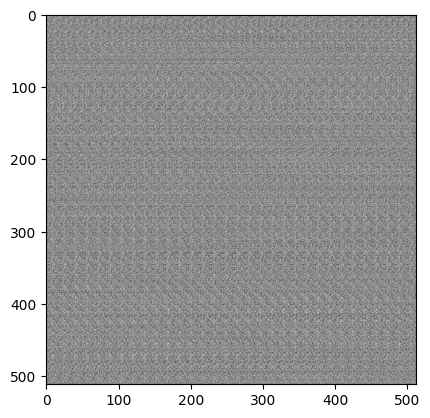

In [285]:
plt.imshow(Yr[0].detach().cpu().permute(1, 2, 0).numpy()[:,:,30], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..227.0].


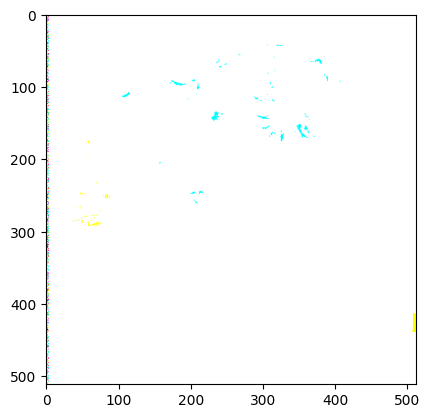

In [258]:
plt.imshow(rgb_batch[0].detach().cpu().permute(1, 2, 0).numpy())

In [227]:
F1.shape, Pspa.shape

(torch.Size([1, 10, 512, 512]), torch.Size([1, 3, 512, 512]))

## Visualization phase

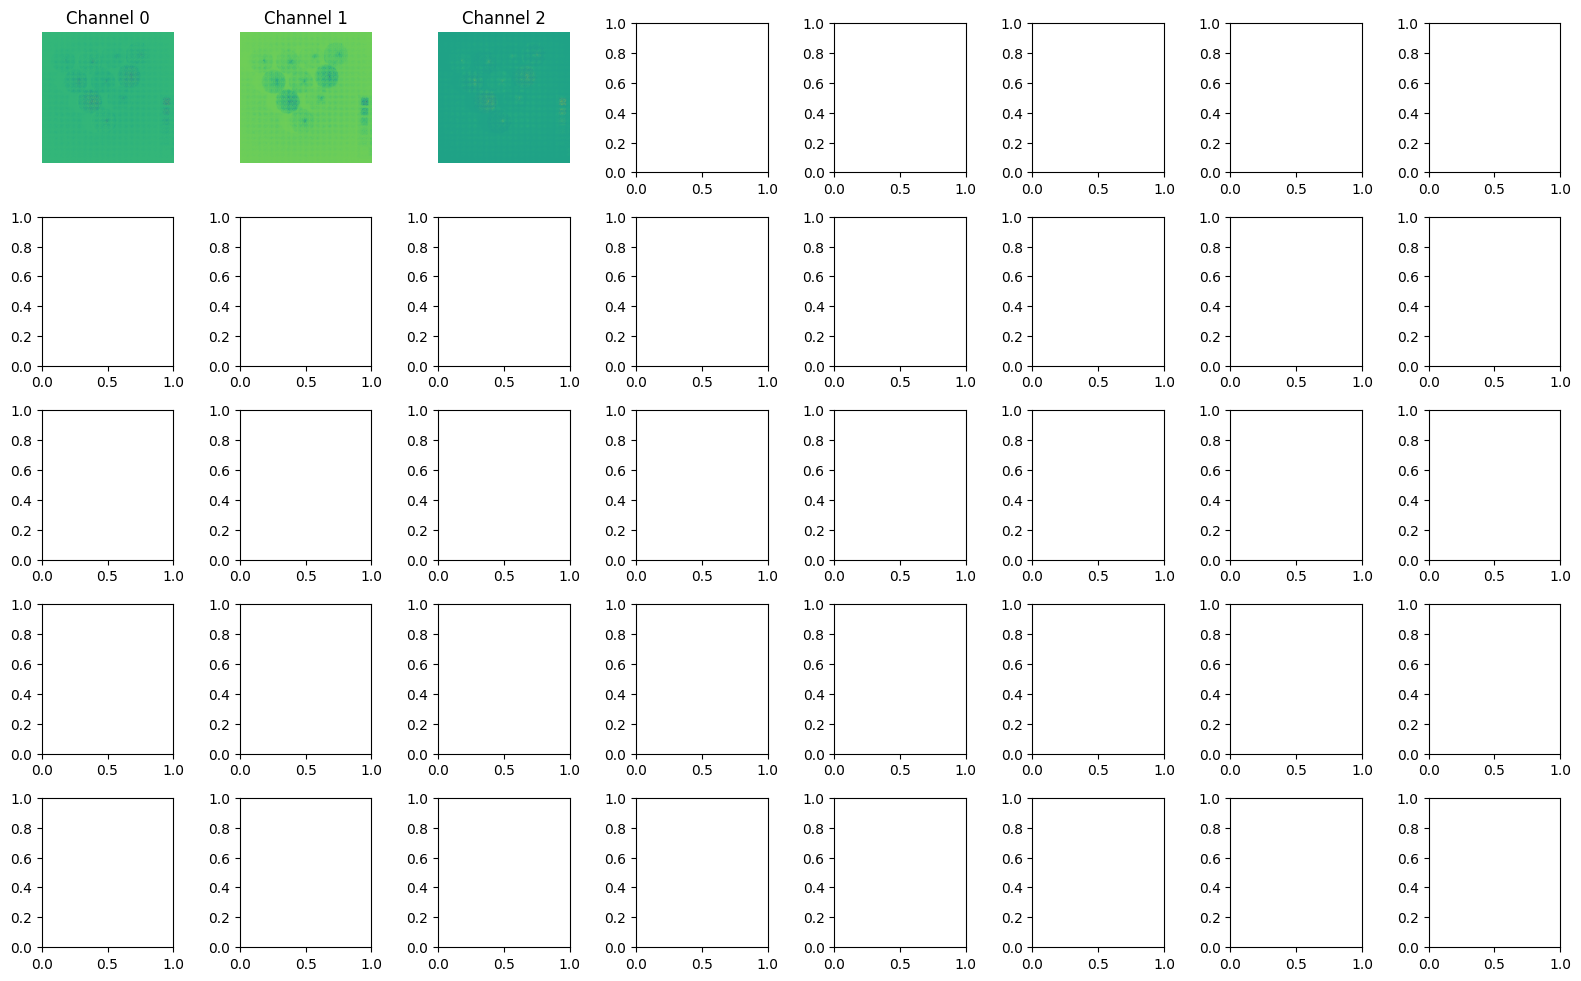

In [228]:
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
channels = Pspa.shape[1]

for idx in range(channels):
    ax = axes[idx // 8, idx % 8]
    ax.imshow(Pspa[0].permute(1, 2, 0).detach().cpu().numpy()[:, :, idx])
    ax.set_title(f"Channel {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()

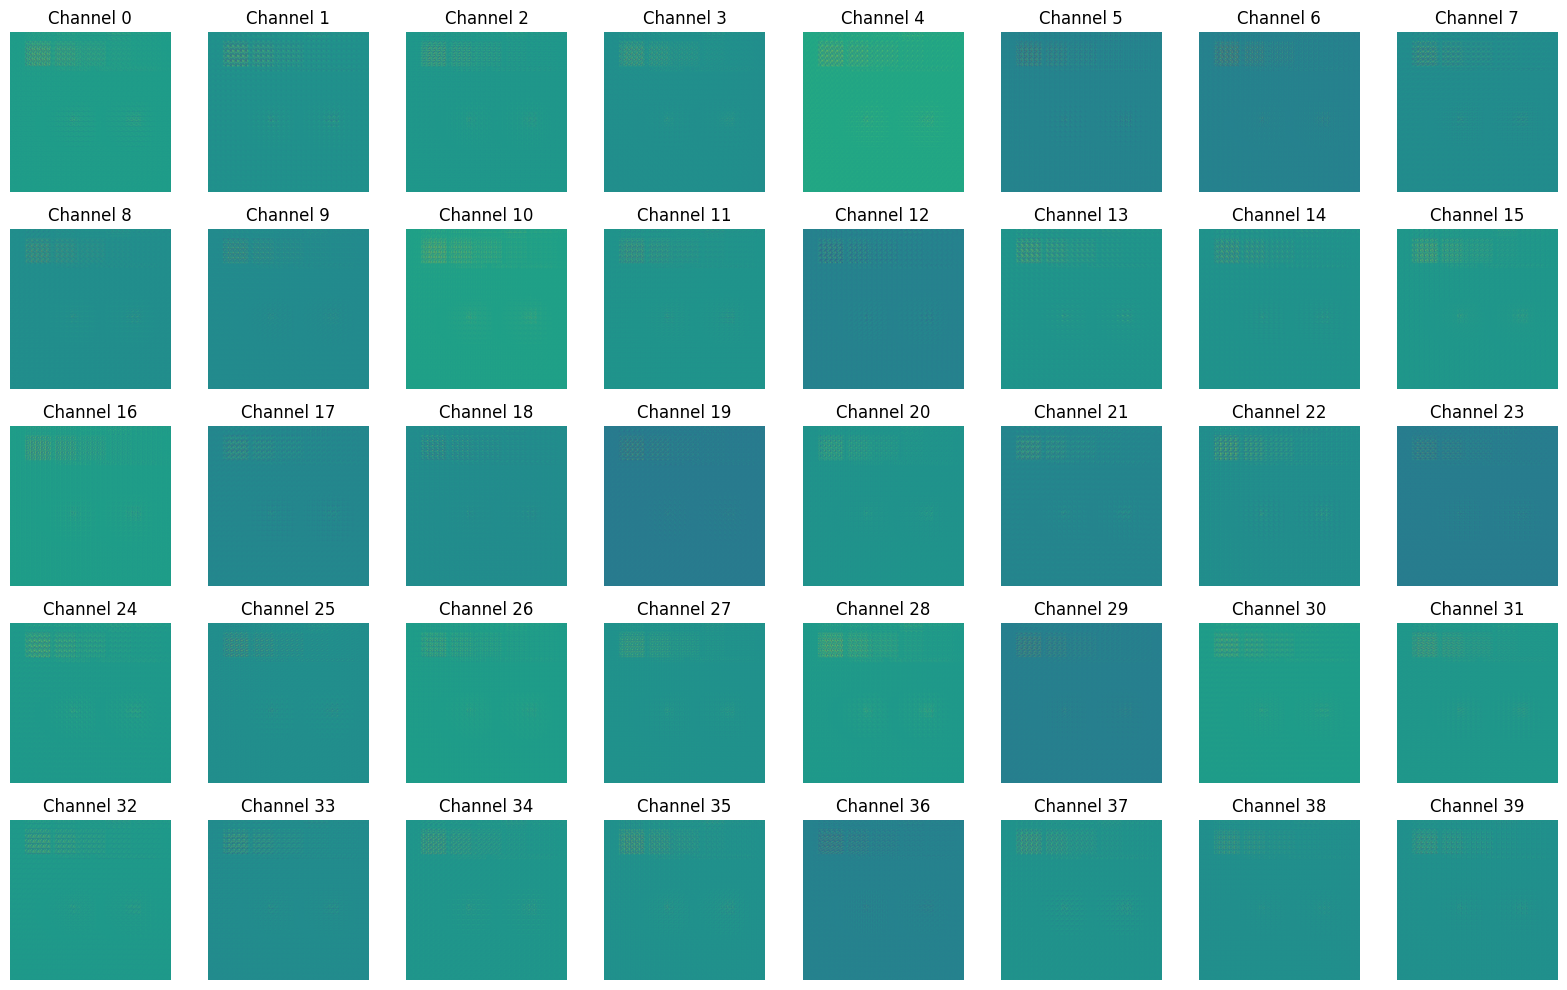

In [25]:
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
channels = spat_out.shape[1]

for idx in range(channels):
    ax = axes[idx // 8, idx % 8]
    ax.imshow(spat_out[0].permute(1, 2, 0).detach().cpu().numpy()[:, :, idx])
    ax.set_title(f"Channel {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [26]:
# testing on 1 image:
rgb_img = rgb_list[0]

In [27]:
normed_rgb = rgb_img/255

In [28]:
normed_rgb.shape

(512, 512, 3)

In [29]:
conv1 = nn.Conv2d(3, 40, kernel_size=3, padding=1)
testf1 = conv1(torch.tensor(normed_rgb, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2))  # (1, 40, H, W)

In [32]:
B,C,H,W = testf1.shape
P = 16
patches = F.unfold(testf1, kernel_size=16, stride=16)
print(f"patches shape: {patches.shape}")  # (B, C*P*P, num_patches)
num_patches = patches.size(-1)

patches shape: torch.Size([1, 10240, 1024])


In [33]:
patches = patches.permute(0, 2, 1).contiguous().view(B, num_patches, C, P, P)

In [34]:
patches.shape

torch.Size([1, 1024, 40, 16, 16])

In [35]:
BN = B * num_patches
patches = patches.view(BN, C, P, P)  # (BN, C, P, P)

In [36]:
patches.shape

torch.Size([1024, 40, 16, 16])

In [40]:
F1[0][0].shape

torch.Size([512, 512])

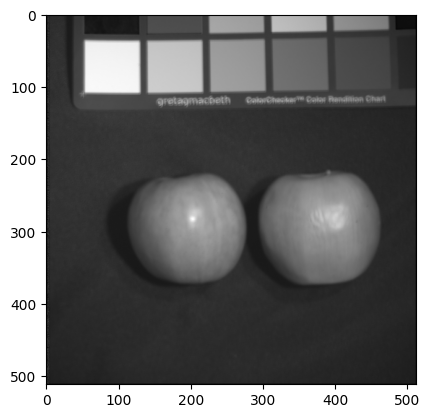

In [47]:
plt.imshow(F1[0][1].detach().cpu().numpy(), cmap='gray')

In [179]:
from torch_frft.frft_module import frft, frft_shifted, ifrft

a0, a1 = 0.5, 0.5 

fracFT = frft(frft(F1[0][1], a0, dim=-2), a1, dim=-1)
shiftedFRFT = frft_shifted(fracFT, 1)

from torch_frft.dfrft_module import dfrft, idfrft
dfracFT = dfrft(dfrft(F1[0][1], a0, dim=-2), a1, dim=-1)
shiftedDFRFT = frft_shifted(dfracFT, 1)

inverse = ifrft(ifrft(fracFT, a0, dim=-2), a1, dim=-1)
inverse_shifted = ifrft(ifrft(shiftedFRFT, a0, dim=-2), a1, dim=-1)

inverse_dfrft = idfrft(idfrft(dfracFT, a0, dim=-2), a1, dim=-1)
inverse_shifted_dfrft = idfrft(idfrft(shiftedDFRFT, a0, dim=-2), a1, dim=-1)

In [195]:
print(fracFT.shape)
fracFTun = fracFT.unsqueeze(0) 
print(fracFT.shape)
Ff_real = fracFTun.real
Ff_imag = fracFTun.imag
Fss = torch.complex(Ff_real, Ff_imag)  # combine real and imaginary parts
error = Fss - fracFTun
print("Error between original and complex representation:", error)
Ff_cat = torch.cat([Ff_real, Ff_imag], dim=0)
print(Ff_cat.shape)

torch.Size([512, 512])
torch.Size([512, 512])
Error between original and complex representation: tensor([[[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]]],
       grad_fn=<SubBackward0>)
torch.Size([2, 512, 512])


In [197]:

# Project back to C channels so MScanBlock sees float
Ff_real = nn.Conv2d(1 , 1, 1)(Ff_real)
Ff_imag = nn.Conv2d(1 , 1, 1)(Ff_imag)
Ff_s = torch.complex(Ff_real, Ff_imag)  # combine real and imaginary parts
error = Ff_s - fracFTun
print("Error after projection:", error.abs().max().item())

Error after projection: 395.4969482421875


In [182]:
Ff_conv.shape, Ff_real.shape, Ff_imag.shape

(torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512]))

In [188]:
inverse = ifrft(ifrft(torch.abs(fracFT), a0, dim=-2), a1, dim=-1)
inverse.shape

torch.Size([512, 512])

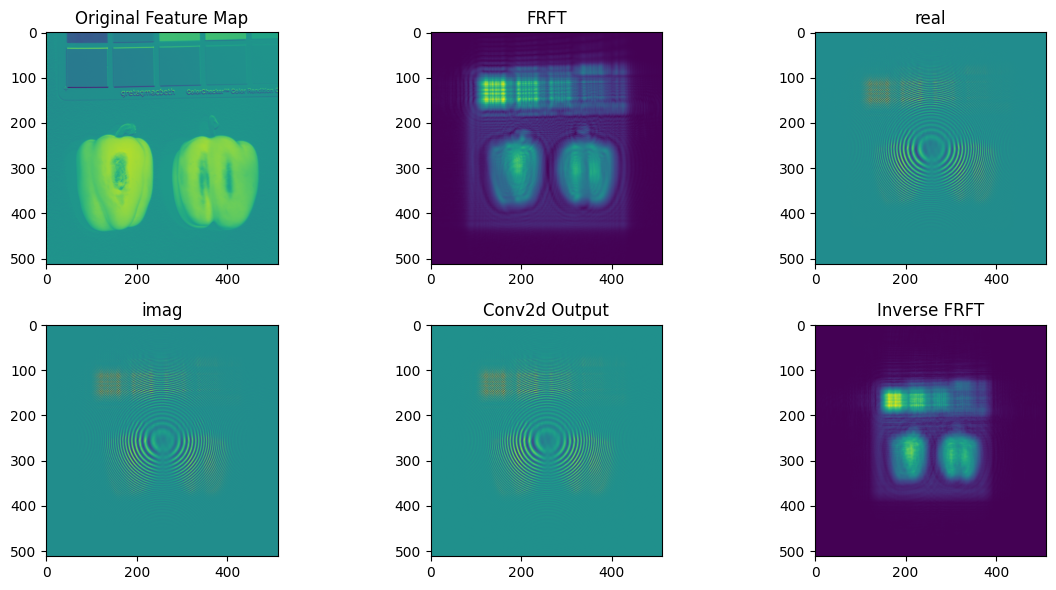

In [190]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(F1[0][12].detach().cpu().numpy())
plt.title("Original Feature Map")

plt.subplot(2, 3, 2)
plt.imshow(np.abs(fracFT.detach().cpu().numpy()))
plt.title("FRFT")

plt.subplot(2, 3, 3)
plt.imshow(Ff_real[0].detach().cpu().numpy())
plt.title("real")

plt.subplot(2, 3, 4)
plt.imshow(Ff_imag[0].detach().cpu().numpy())
plt.title("imag")

plt.subplot(2, 3, 5)
plt.imshow(Ff_conv[0].detach().cpu().numpy())
plt.title("Conv2d Output")

plt.subplot(2, 3, 6)
plt.imshow(np.abs(inverse.detach().cpu().numpy()))
plt.title("Inverse FRFT")

plt.tight_layout()

In [215]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpaHF(nn.Module):
    """
    Spa-HF Prompt (P_hf)
    F2 = up(avgpool(F1))
    P_hf = Conv3x3(GELU(Conv3x3(F1 - F2)))

    Args:
        C:        # channels of F1
        pool:     pooling factor (int or tuple). e.g., 2, 4
        up_mode:  'bilinear' (default) or 'nearest'
    """
    def __init__(self, C, pool=2, up_mode='bilinear'):
        super().__init__()
        self.avg = nn.AvgPool2d(kernel_size=pool, stride=pool)
        # upsample back to original size
        if up_mode == 'bilinear':
            self.up = lambda x, size: F.interpolate(x, size=size, mode='bilinear', align_corners=False)
        else:
            self.up = lambda x, size: F.interpolate(x, size=size, mode='nearest')

        self.refine = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=3, padding=1),
            nn.GELU(),                      # M_GeLU
            nn.Conv2d(C, 3, kernel_size=3, padding=1)
        )

    def forward(self, F1):                   # F1: (B, C, H, W)
        H, W = F1.shape[-2:]
        F2_low = self.avg(F1)                # low-pass
        F2 = self.up(F2_low, size=(H, W))    # back to (H,W)
        hf = F1 - F2                         # high-frequency residue
        Phf = self.refine(hf)                # two 3x3 + GeLU
        return Phf, F2, hf                   # return extras if you want to visualize


In [216]:
test = SpaHF(C=10, pool=2, up_mode='bilinear')
P_hf, F2, hf = test(F1)

In [217]:
P_hf.shape, F2.shape, hf.shape

(torch.Size([1, 3, 512, 512]),
 torch.Size([1, 10, 512, 512]),
 torch.Size([1, 10, 512, 512]))

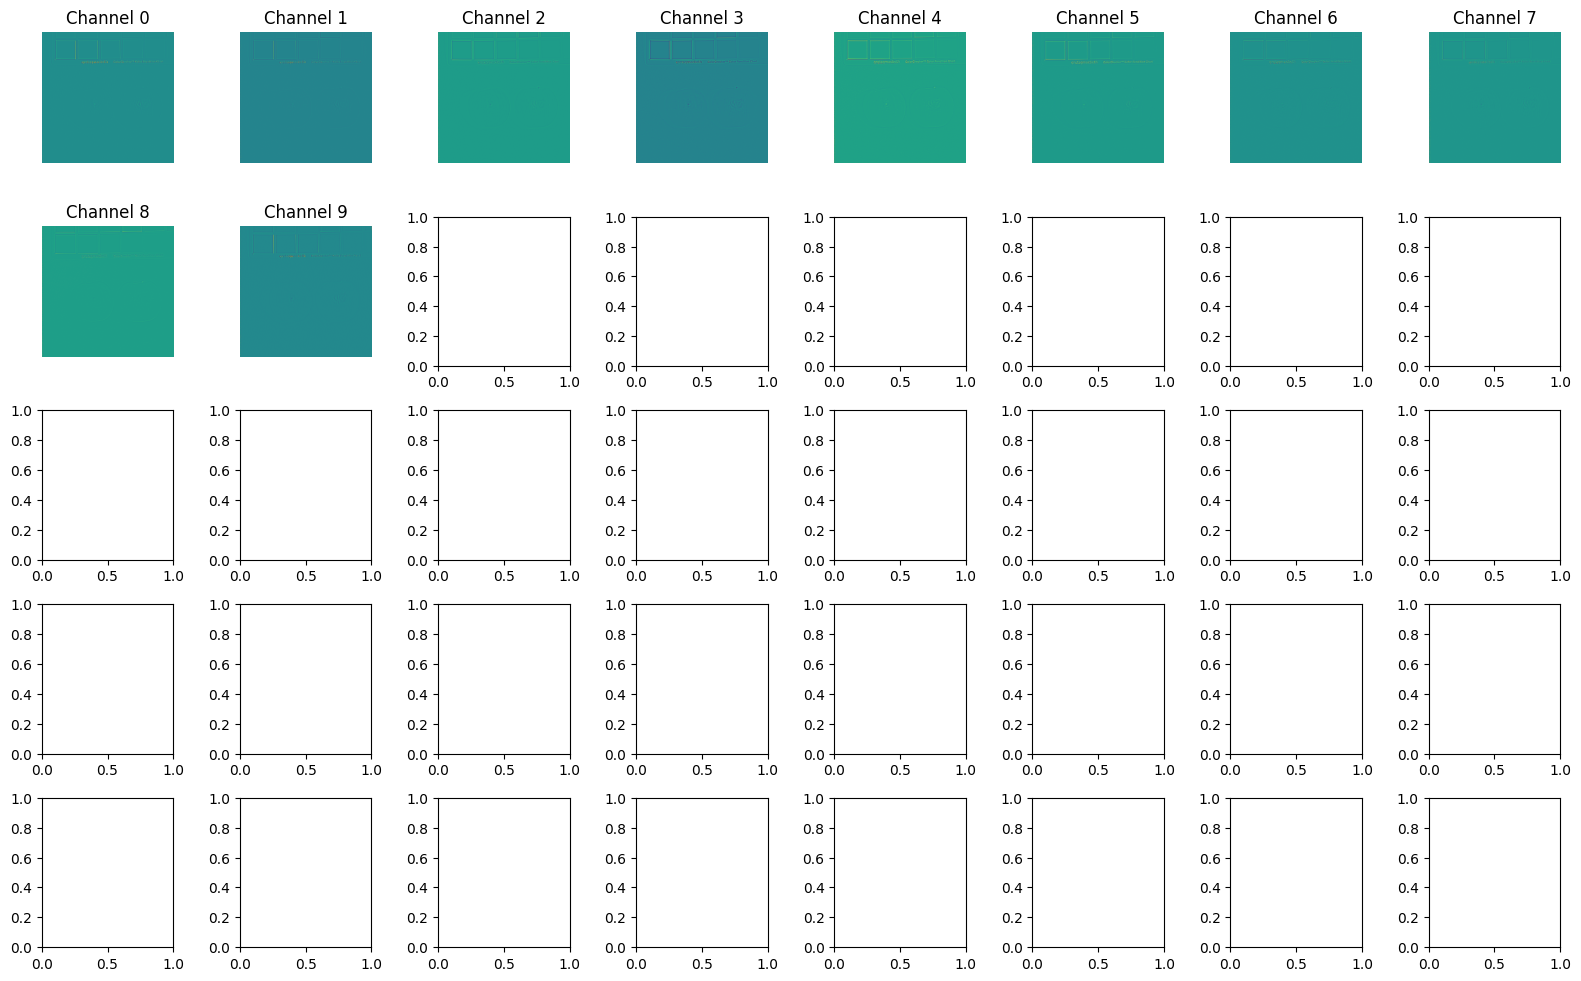

In [230]:
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
channels = hf.shape[1]

for idx in range(channels):
    ax = axes[idx // 8, idx % 8]
    ax.imshow(hf[0].permute(1, 2, 0).detach().cpu().numpy()[:, :, idx])
    ax.set_title(f"Channel {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()